<a href="https://colab.research.google.com/github/gowtham8666/Amazon-product-recommendationn-system/blob/main/Copy_of_Amzon_product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195783 sha256=0830d9350f9a5a881e85a01e137839ea08c23713bfc25519c7407c2761958e32
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


# Dataset description 

# Importing dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Split
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import os

# Data loading

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/AmazonproductRecommendation/ratings_Electronics.csv",
                             names=['userId', 'productId','rating','timestamp'])

# Exploratory Data Analysis

In [ ]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [ ]:
# Taking subset of the dataset
df = df.iloc[:5000,0:]

In [ ]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 5000
Total Columns: 4


In [ ]:
print("Total number of ratings :",df.rating.nunique())
print("Total number of users   :", df.userId.nunique())
print("Total number of products  :", df.productId.nunique())

Total number of ratings : 5
Total number of users   : 4929
Total number of products  : 299


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     5000 non-null   object 
 1   productId  5000 non-null   object 
 2   rating     5000 non-null   float64
 3   timestamp  5000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 156.4+ KB


In [ ]:
# Check missing value
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [ ]:
# Check Duplicate data
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [ ]:
# rating describe summary 
df.describe()['rating']

count    5000.000000
mean        3.986600
std         1.411814
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [ ]:
print("Unique value of Rating:",df.rating.unique())

Unique value of Rating: [5. 1. 3. 2. 4.]


In [ ]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [ ]:
# Average rating of products
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


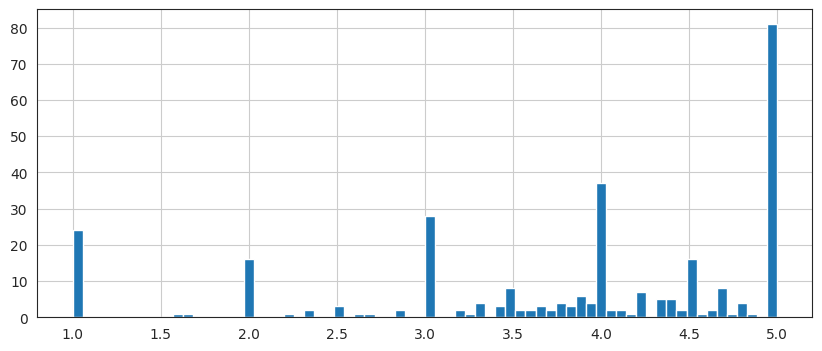

In [ ]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)
plt.show()

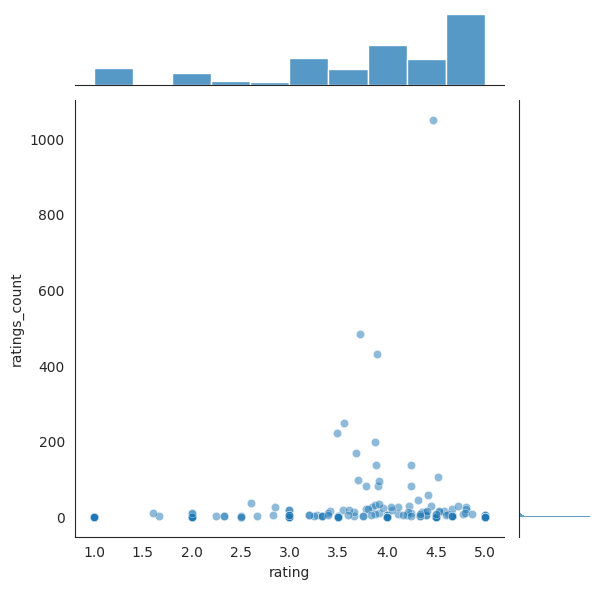

In [ ]:
sns.jointplot(x='rating',y='ratings_count',data=ratings,alpha=0.5)
plt.show()

<Axes: xlabel='productId'>

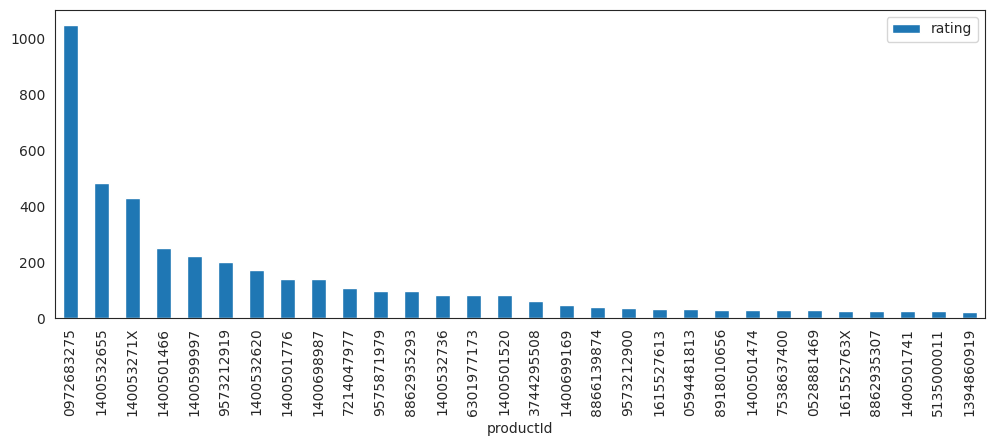

In [ ]:
# Most top 30 products
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

# Recommendation systems

## Popularity based recommendation system

In [ ]:
vote_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
vote_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = vote_averages.mean()
print("Average rating of product across the whole dataset is",C)

Average rating of product across the whole dataset is 3.5953177257525084


In [ ]:
m = vote_counts.quantile(0.95)
print("Minimum votes required to be listed in the chart is",m)

Minimum votes required to be listed in the chart is 62.19999999999925


In [ ]:
ratings.head()

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852


In [ ]:
qualified = ratings[(ratings['ratings_count'] >= m) & (ratings['ratings_count'].notnull()) & (ratings['ratings_average'].notnull())][['ratings_count', 'ratings_average']]

In [ ]:
qualified['ratings_count'] = qualified['ratings_count'].astype('int')
qualified['ratings_average'] = qualified['ratings_average'].astype('int')
qualified.head().sort_values(by='ratings_count', ascending=False)

,ratings_count,ratings_average
productId,,
0972683275,1051,4
1400501466,250,3
1400532620,171,3
1400501776,139,3
1400501520,82,4


In [ ]:
qualified.shape

(15, 2)

In [ ]:
def weighted_rating(x):
    v = x['ratings_count']
    R = x['ratings_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('wr', ascending=False).head(20)

In [ ]:
qualified.head(10)

,ratings_count,ratings_average,wr
productId,,,
0972683275,1051,4,3.977388
1400698987,138,4,3.874270
7214047977,107,4,3.851234
1400501520,82,4,3.825442
6301977173,83,3,3.255019
1400532736,84,3,3.253275
8862935293,95,3,3.235552
9575871979,98,3,3.231141
1400501776,139,3,3.184040


Text(0, 0.5, 'Count')

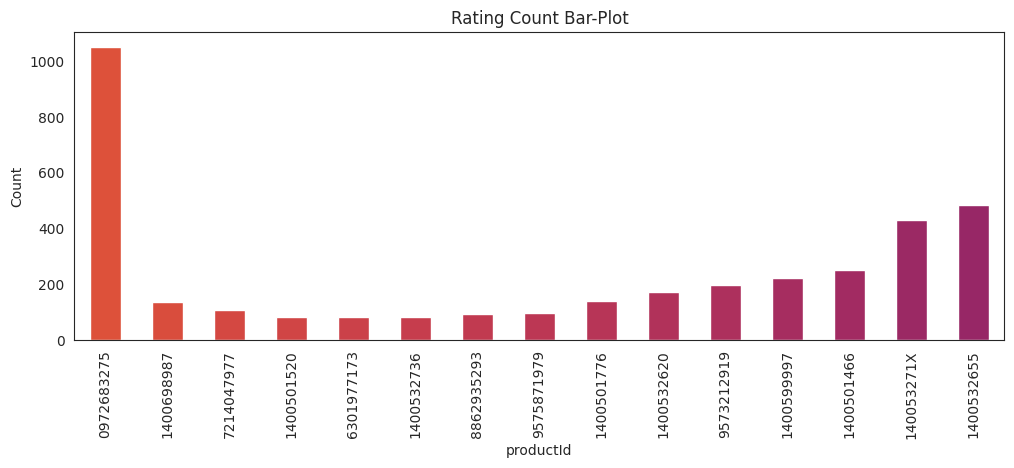

In [ ]:
# Add color
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

rating_plot_count = qualified['ratings_count'].plot.bar(figsize=(12, 4),color=color)
rating_plot_count.set_title("Rating Count Bar-Plot")
rating_plot_count.set_xlabel("productId")
rating_plot_count.set_ylabel("Count")

Text(0, 0.5, 'rating')

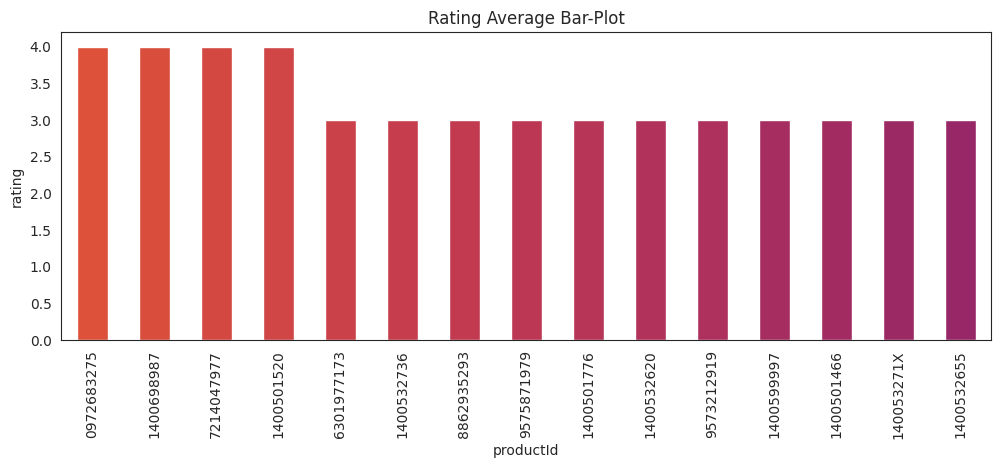

In [ ]:
rating_plot_avg = qualified['ratings_average'].plot.bar(figsize=(12, 4),color=color)
rating_plot_avg.set_title("Rating Average Bar-Plot")
rating_plot_avg.set_xlabel("productId")
rating_plot_avg.set_ylabel("rating")

Text(0, 0.5, 'rating')

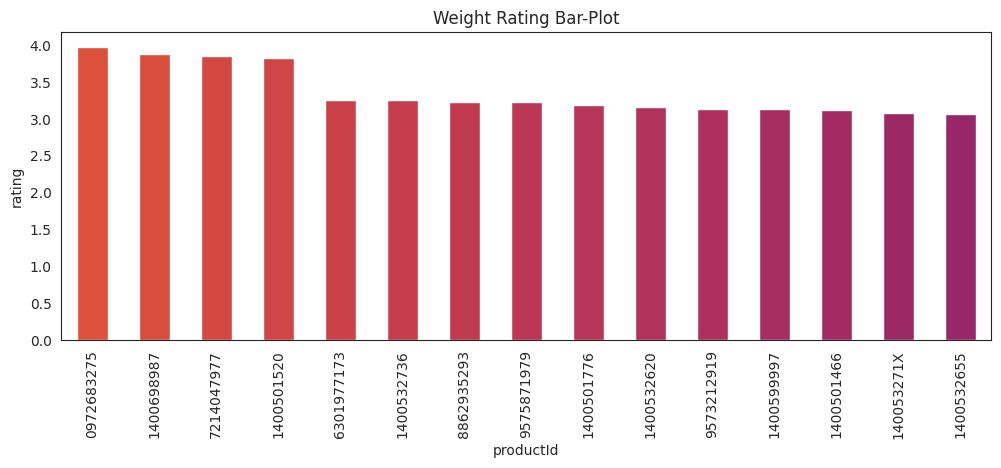

In [ ]:
wr_plot = qualified['wr'].plot.bar(figsize=(12, 4),color=color)
wr_plot.set_title("Weight Rating Bar-Plot")
wr_plot.set_xlabel("productId")
wr_plot.set_ylabel("rating")

### Collaberative filtering (User-Item recommedation)


In [ ]:
reader = Reader()

In [ ]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
data = Dataset.load_from_df(df[['userId', 'productId', 'rating']], reader)

In [ ]:
# Use the famous SVD algorithm
svd = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3226  1.3965  1.3882  1.3494  1.3471  1.3608  0.0276  
MAE (testset)     1.0693  1.1167  1.1244  1.1111  1.0952  1.1033  0.0195  
Fit time          0.18    0.51    0.28    0.28    0.22    0.29    0.12    
Test time         0.03    0.02    0.04    0.02    0.01    0.02    0.01    


{'test_rmse': array([1.32260116, 1.39650321, 1.38815626, 1.34944758, 1.34712184]),
 'test_mae': array([1.06931164, 1.11669724, 1.12440977, 1.11107496, 1.09520822]),
 'fit_time': (0.17682385444641113,
  0.5113162994384766,
  0.2827935218811035,
  0.284069299697876,
  0.21943998336791992),
 'test_time': (0.025206327438354492,
  0.024740219116210938,
  0.03717041015625,
  0.022292375564575195,
  0.009176492691040039)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
df['userId'].value_counts()

A3LDPF5FMB782Z    5
A36V8NDDRZYRYO    3
A3E7PG9CHDBICA    3
AOY9SZTMNQWAW     3
A2FHM5FB0BXKGA    3
                 ..
A1W92X1R9QNM2C    1
A1KW4AGRCOIWI2    1
A1B6WHCBJSNO6J    1
A3BEVLI33Q0ZF4    1
A1TYKVIT4FTMRO    1
Name: userId, Length: 4929, dtype: int64

In [ ]:
# Check specific userId review
df[df['userId'] == 'A3LDPF5FMB782Z']

,userId,productId,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1588,A3LDPF5FMB782Z,1400501520,5.0,1362873600
1696,A3LDPF5FMB782Z,1400501776,5.0,1334102400
2502,A3LDPF5FMB782Z,140053271X,4.0,1310515200
3235,A3LDPF5FMB782Z,1400698987,4.0,1392854400


In [ ]:
# predict based on this data
svd.predict('A3LDPF5FMB782Z', '140053271X', 5.0)

Prediction(uid='A3LDPF5FMB782Z', iid='140053271X', r_ui=5.0, est=3.7188500195371343, details={'was_impossible': False})